In [1]:
# This is an example script. It can be modified to your personal needs.
# Specify path to data, path to wtref, output paths for plots and txt file, 
# file type for plots, name of files, scale and desired mode of analysis.
# Input paths for data and wtref with a list of names of the measurement files

In [2]:
# -*- coding: utf-8 -*-
import numpy as np
import logging
#Imports
import os
import sys
# Add the parent directory to the path
#sys.path.append(os.path.abspath("/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/windtunnel_software/Windtunnel_Software/Update 20240624/windtunnel-master"))
sys.path.append(os.path.abspath("/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare"))
import windtunnel as wt
import matplotlib.pyplot as plt
# Create logger
logger = logging.getLogger()

In [3]:
#%%#
#path = 'Z:/projects/BFS/raw measurements/boundary layer/time series/' # path to timeseries folder
#path="/home/sabrina/Schreibtisch/Arbeit_2025/windtunnel_software/Data/"
#path ="/home/sabrina/48/LDA/"
path ="/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/FreeCAD/UBA/vertikales Profil/Zeitserien/"
#wtref_path = '/home/sabrina/' #'Z:/projects/BFS/raw measurements/boundary layer/wtref/'
#wtref_path="/home/sabrina/48/USA/Flowtest_UV_48"
wtref_path="/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/FreeCAD/UBA/vertikales Profil/wtref/"
#namelist = ['Flowtest_UV_48.000001.txt']
namelist = ['UBA_BL_Rep2025_UW_01']
#namelist = ['UBA_BL_Rep2025_UW_01.000001.txt']
#namelist = ['BFS_BD3_MP01_000_01']
#namelist = ['BFS_BD3_MP01_000_01.ts#0']#['BFS_BL_DOC_UV_01'] 

#txt_path = 'path/to your/txt-spectra and mean folder/'
#txt_path = '/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/windtunnel_software/Data/' #None
#txt_path = "/home/sabrina/48/USA/"
txt_path = "/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/FreeCAD/UBA/vertikales Profil/Zeitserien/"
#edit 06/20/19: set ref_path to none for unknown reference path

#ref_path  =None
ref_path ="/home/sabrina/48/USA/"
#ref_path = '//cifs-isi03.cen.uni-hamburg.de/ewtl/work/_EWTL Software/Python/Reference data/'

#plot_path = '//cifs-isi03.cen.uni-hamburg.de/ewtl/projects/UBA/Raw measurements/Boundary Layer/plots/'
#plot_path = 'path/to your/plot-folder'
plot_path = '/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/windtunnel_software/TestPlots/'
out_dir = '/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/' #path/to your/txt-folder/for Timeseries-txt/'
#ref_path = None

In [4]:
header_information = {"[main project name]" : 'BFS',
                      "[sub project name]" : 'Boundary layer',
                      "[wind tunnel facility]" : 'WOTAN',
                      "[model scale]" : 200,
                      "[Zref - model scale[mm]]" : 200,
                      "[wind direction [°]]" : 0,
                      "[Lref - model scale[m]]" : 1/200,
                      "[number of columns]" : 3,
                      "[directly measured components]" : 'UW',
                      "[confidence intervall (U,V,W)/Uref[-]]" : 0.03
    }
scale = header_information["[model scale]"]
scale_factor = 0.6568 #1 #scaling for wtref to 40m over ground levelin fs
data_nd=0 #0/1 input data is non.dimensional/dimensional, set data_nd to 1 if using non-dimensional data


file_type = 'png'

mode = 1
# 1 = vertical profile
# 2 = lateral profile
# 3 = convergence test
# 4 = Reynolds Number Independence
# 5 = Langitudinal profil

checker = True #If True: extra check if positions from header

#plot scatter
plot = True
scatter = True
save_data = True
new_VDI_ref = True #False #True

#Customized (Turbulenz-)Plots variables
z_axis_lim = (None,None) #(min,max) both values must be given or None
dpi= 300
shown_z_value = (None, None) #(min, max) masking data higher or lower 

#edit 08/08/2019: add errors for all quantities
u_err=0
v_err=0
#u_v_error is for plotting wind data, where u and v are plotted on one plot. 
#It is assumed in this case the error to be plotted is the u error. 
#TODO: modify  code to allow for seperate errors for u and v on the same plot. 
u_v_err=u_err
I_u_err=0.1
I_v_err=0.1
flux_err=0.1
lux_err=0.1

In [5]:
#Initialise dicts of time series objects for each ts in namelist, read in raw data from files
if mode == 2:
    outdata_path = '/path/to/your/outdata_lat/'# format in npz
else:
    outdata_path = plot_path# '/path/to/your/outdata/'# format in npz

# Check if all necessary output directories exist
wt.check_directory(plot_path)
wt.check_directory(txt_path)
time_series = {}
time_series.fromkeys(namelist)
time_series_eq = {} #Create seperate time series for equidistant data
time_series_eq.fromkeys(namelist)

# Gather all files into Timeseries objects, save raw timeseries
for name in namelist:
    files = wt.get_files(path,name)
    time_series[name] = {}
    time_series[name].fromkeys(files)
    time_series_eq[name] = {}
    time_series_eq[name].fromkeys(files)    

In [6]:
#Perform entdimensionalisation, scale change and first statistic calculations
#save time series including header information to out_dir/file

for name in namelist:
    for i,file in enumerate(files):
        ts = wt.Timeseries.from_file(path+file)            
        ts.get_wind_comps(path+file)
        #ts_test = ts
        ts.get_wtref(wtref_path,name,index=i, vscale=scale_factor) #'' = name
        # edit 6/20/19: Assume that input data is dimensional, not non-dimensional

        print(file)
        print(ts.u)
        #non-dimensionalise if data is not already non-dimensional
        if data_nd == 0:
           print('Warning: Assuming that data is dimensional. If using non-dimensional input data, set variable data_nd to 1')
           ts.nondimensionalise()
           print("test")
           print(ts.u)
        else:
           if data_nd == 1:
              []
           else:
              print('Warning: data_nd can only be 1 (for non-dimensional input data) or 0 (for dimensional input data)')        
        #Seperate function to calculate equidistant timesteps   
        
        ts.adapt_scale(scale, Lref = header_information["[Lref - model scale[m]]"])  
        #print(ts.x)
        ts.mask_outliers()
        #Copy time series object from old and do all calculations also for adjusted to equidistant timesteps
        ts_eq=ts
        ts_eq.calc_equidistant_timesteps()  
        ts.index=ts.t_arr
        #Perform time weighted mean and variance calculations
        ts.weighted_component_mean
        ts_eq.weighted_component_mean
        ts.weighted_component_variance
        ts_eq.weighted_component_variance
        ts.mean_magnitude
        ts_eq.mean_magnitude
        ts.mean_direction
        ts_eq.mean_direction
        #Save read in time-series object together with input information
        ts.save2file(file, out_dir = out_dir, header_information=header_information)     
        time_series[name][file] = ts
        time_series_eq[name][file] = ts_eq

if files==[]:
   raise Exception('No Matching File Names Found. Please check namelist and/or path!') 

-2050.0


/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/windtunnel/timeseries.py:120: RuntimeWarning: invalid value encountered in divide
  v_eq=v/v
/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/windtunnel/timeseries.py:41: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.t_arr = t_arr
/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/windtunnel/timeseries.py:42: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.t_transit = t_transit
/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/windtunnel/timeseries.py:45: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-

UBA_BL_Rep2025_UW_01.000001.txt
0        2.317
1        2.147
2        1.939
3        2.184
4        2.528
         ...  
41835    1.520
41836    1.860
41837    1.936
41838    1.865
41839    1.871
Name: u, Length: 41840, dtype: float64
test
0        0.606170
1        0.561695
2        0.507279
3        0.571375
4        0.661372
           ...   
41835    0.397660
41836    0.486611
41837    0.506494
41838    0.487919
41839    0.489489
Name: u, Length: 41840, dtype: float64
-2050.0


/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/windtunnel/timeseries.py:120: RuntimeWarning: invalid value encountered in divide
  v_eq=v/v
/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/windtunnel/timeseries.py:41: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.t_arr = t_arr
/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/windtunnel/timeseries.py:42: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.t_transit = t_transit
/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/windtunnel/timeseries.py:45: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-

UBA_BL_Rep2025_UW_01.000002.txt
0        2.306
1        2.469
2        3.510
3        3.107
4        2.978
         ...  
40932    1.792
40933    1.706
40934    1.675
40935    1.627
40936    1.721
Name: u, Length: 40937, dtype: float64
test
0        0.601093
1        0.643582
2        0.914934
3        0.809886
4        0.776260
           ...   
40932    0.467111
40933    0.444694
40934    0.436614
40935    0.424102
40936    0.448604
Name: u, Length: 40937, dtype: float64
-2050.0


/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/windtunnel/timeseries.py:120: RuntimeWarning: invalid value encountered in divide
  v_eq=v/v
/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/windtunnel/timeseries.py:41: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.t_arr = t_arr
/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/windtunnel/timeseries.py:42: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.t_transit = t_transit
/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/windtunnel/timeseries.py:45: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-

UBA_BL_Rep2025_UW_01.000003.txt
0        2.216
1        2.287
2        2.364
3        2.410
4        2.345
         ...  
42211    2.988
42212    3.142
42213    2.650
42214    2.628
42215    2.945
Name: u, Length: 42216, dtype: float64
test
0        0.579927
1        0.598507
2        0.618658
3        0.630696
4        0.613686
           ...   
42211    0.781959
42212    0.822261
42213    0.693504
42214    0.687747
42215    0.770706
Name: u, Length: 42216, dtype: float64
-2050.0


/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/windtunnel/timeseries.py:120: RuntimeWarning: invalid value encountered in divide
  v_eq=v/v
/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/windtunnel/timeseries.py:41: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.t_arr = t_arr
/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/windtunnel/timeseries.py:42: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.t_transit = t_transit
/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/windtunnel/timeseries.py:45: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-

UBA_BL_Rep2025_UW_01.000004.txt
0        2.528
1        2.337
2        2.223
3        2.058
4        2.044
         ...  
42383    2.689
42384    2.855
42385    2.920
42386    2.720
42387    2.710
Name: u, Length: 42388, dtype: float64
test
0        0.662496
1        0.612442
2        0.582567
3        0.539326
4        0.535657
           ...   
42383    0.704688
42384    0.748191
42385    0.765225
42386    0.712812
42387    0.710192
Name: u, Length: 42388, dtype: float64
-2050.0


/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/windtunnel/timeseries.py:120: RuntimeWarning: invalid value encountered in divide
  v_eq=v/v
/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/windtunnel/timeseries.py:41: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.t_arr = t_arr
/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/windtunnel/timeseries.py:42: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.t_transit = t_transit
/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/windtunnel/timeseries.py:45: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-

UBA_BL_Rep2025_UW_01.000005.txt
0        2.938
1        2.898
2        3.261
3        3.323
4        3.531
         ...  
42995    2.601
42996    2.277
42997    2.444
42998    2.447
42999    2.460
Name: u, Length: 43000, dtype: float64
test
0        0.765842
1        0.755416
2        0.850038
3        0.866200
4        0.920418
           ...   
42995    0.677997
42996    0.593541
42997    0.637072
42998    0.637854
42999    0.641243
Name: u, Length: 43000, dtype: float64
-2050.0


/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/windtunnel/timeseries.py:120: RuntimeWarning: invalid value encountered in divide
  v_eq=v/v
/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/windtunnel/timeseries.py:41: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.t_arr = t_arr
/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/windtunnel/timeseries.py:42: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.t_transit = t_transit
/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/windtunnel/timeseries.py:45: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-

UBA_BL_Rep2025_UW_01.000006.txt
0        2.888
1        2.843
2        3.068
3        2.579
4        2.625
         ...  
43030    3.172
43031    3.266
43032    3.178
43033    3.603
43034    3.516
Name: u, Length: 43035, dtype: float64
test
0        0.754875
1        0.743113
2        0.801924
3        0.674108
4        0.686132
           ...   
43030    0.829108
43031    0.853678
43032    0.830677
43033    0.941765
43034    0.919024
Name: u, Length: 43035, dtype: float64
-2050.0


/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/windtunnel/timeseries.py:120: RuntimeWarning: invalid value encountered in divide
  v_eq=v/v
/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/windtunnel/timeseries.py:41: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.t_arr = t_arr
/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/windtunnel/timeseries.py:42: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.t_transit = t_transit
/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/windtunnel/timeseries.py:45: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-

UBA_BL_Rep2025_UW_01.000007.txt
0        1.566
1        3.007
2        2.586
3        3.451
4        3.037
         ...  
47039    3.401
47040    3.312
47041    3.202
47042    3.080
47043    2.900
Name: u, Length: 47044, dtype: float64
test
0        0.410712
1        0.788641
2        0.678226
3        0.905088
4        0.796509
           ...   
47039    0.891975
47040    0.868633
47041    0.839783
47042    0.807787
47043    0.760578
Name: u, Length: 47044, dtype: float64
-2050.0


/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/windtunnel/timeseries.py:120: RuntimeWarning: invalid value encountered in divide
  v_eq=v/v
/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/windtunnel/timeseries.py:41: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.t_arr = t_arr
/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/windtunnel/timeseries.py:42: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.t_transit = t_transit
/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/windtunnel/timeseries.py:45: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-

UBA_BL_Rep2025_UW_01.000008.txt
0        3.818
1        3.622
2        3.612
3        3.447
4        3.439
         ...  
61212    2.198
61213    2.207
61214    2.138
61215    2.325
61216    2.228
Name: u, Length: 61217, dtype: float64
test
0        1.000214
1        0.948867
2        0.946247
3        0.903022
4        0.900926
           ...   
61212    0.575817
61213    0.578175
61214    0.560099
61215    0.609088
61216    0.583676
Name: u, Length: 61217, dtype: float64
-2050.0


/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/windtunnel/timeseries.py:120: RuntimeWarning: invalid value encountered in divide
  v_eq=v/v
/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/windtunnel/timeseries.py:41: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.t_arr = t_arr
/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/windtunnel/timeseries.py:42: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.t_transit = t_transit
/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/windtunnel/timeseries.py:45: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-

UBA_BL_Rep2025_UW_01.000009.txt
0        3.177
1        3.152
2        3.438
3        3.577
4        3.546
         ...  
62059    3.008
62060    2.884
62061    3.037
62062    3.004
62063    2.713
Name: u, Length: 62064, dtype: float64
test
0        0.828258
1        0.821740
2        0.896301
3        0.932539
4        0.924457
           ...   
62059    0.784199
62060    0.751871
62061    0.791759
62062    0.783156
62063    0.707291
Name: u, Length: 62064, dtype: float64
-2050.0


/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/windtunnel/timeseries.py:120: RuntimeWarning: invalid value encountered in divide
  v_eq=v/v
/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/windtunnel/timeseries.py:41: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.t_arr = t_arr
/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/windtunnel/timeseries.py:42: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.t_transit = t_transit
/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/windtunnel/timeseries.py:45: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-

UBA_BL_Rep2025_UW_01.000010.txt
0        2.980
1        2.865
2        2.851
3        2.839
4        2.803
         ...  
65118    4.018
65119    3.543
65120    3.580
65121    3.203
65122    3.099
Name: u, Length: 65123, dtype: float64
test
0        0.776621
1        0.746651
2        0.743003
3        0.739875
4        0.730493
           ...   
65118    1.047136
65119    0.923346
65120    0.932988
65121    0.834738
65122    0.807634
Name: u, Length: 65123, dtype: float64
-2050.0


/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/windtunnel/timeseries.py:120: RuntimeWarning: invalid value encountered in divide
  v_eq=v/v
/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/windtunnel/timeseries.py:41: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.t_arr = t_arr
/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/windtunnel/timeseries.py:42: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.t_transit = t_transit
/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/windtunnel/timeseries.py:45: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-

UBA_BL_Rep2025_UW_01.000011.txt
0        3.392
1        3.363
2        3.191
3        3.392
4        3.192
         ...  
64625    2.717
64626    2.666
64627    2.640
64628    2.729
64629    2.641
Name: u, Length: 64630, dtype: float64
test
0        0.884388
1        0.876827
2        0.831981
3        0.884388
4        0.832242
           ...   
64625    0.708397
64626    0.695099
64627    0.688321
64628    0.711525
64629    0.688581
Name: u, Length: 64630, dtype: float64
-2050.0


/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/windtunnel/timeseries.py:120: RuntimeWarning: invalid value encountered in divide
  v_eq=v/v
/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/windtunnel/timeseries.py:41: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.t_arr = t_arr
/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/windtunnel/timeseries.py:42: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.t_transit = t_transit
/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/windtunnel/timeseries.py:45: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-

UBA_BL_Rep2025_UW_01.000012.txt
0        3.940
1        4.005
2        3.921
3        3.880
4        4.105
         ...  
63267    3.927
63268    3.999
63269    3.928
63270    4.024
63271    3.944
Name: u, Length: 63272, dtype: float64
test
0        1.031096
1        1.048107
2        1.026124
3        1.015394
4        1.074277
           ...   
63267    1.027694
63268    1.046537
63269    1.027956
63270    1.053079
63271    1.032143
Name: u, Length: 63272, dtype: float64
-2050.0


/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/windtunnel/timeseries.py:120: RuntimeWarning: invalid value encountered in divide
  v_eq=v/v
/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/windtunnel/timeseries.py:41: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.t_arr = t_arr
/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/windtunnel/timeseries.py:42: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.t_transit = t_transit
/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/windtunnel/timeseries.py:45: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-

UBA_BL_Rep2025_UW_01.000013.txt
0        2.618
1        2.776
2        2.929
3        2.839
4        2.811
         ...  
67313    2.956
67314    2.988
67315    3.001
67316    2.987
67317    2.850
Name: u, Length: 67318, dtype: float64
test
0        0.685273
1        0.726630
2        0.766679
3        0.743121
4        0.735792
           ...   
67313    0.773746
67314    0.782122
67315    0.785525
67316    0.781861
67317    0.746000
Name: u, Length: 67318, dtype: float64
-2050.0


/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/windtunnel/timeseries.py:120: RuntimeWarning: invalid value encountered in divide
  v_eq=v/v
/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/windtunnel/timeseries.py:41: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.t_arr = t_arr
/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/windtunnel/timeseries.py:42: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.t_transit = t_transit
/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/windtunnel/timeseries.py:45: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-

UBA_BL_Rep2025_UW_01.000014.txt
0        3.612
1        3.916
2        3.821
3        3.878
4        3.939
         ...  
66160    2.703
66161    2.779
66162    2.806
66163    2.990
66164    3.000
Name: u, Length: 66165, dtype: float64
test
0        0.940878
1        1.020066
2        0.995319
3        1.010167
4        1.026057
           ...   
66160    0.704095
66161    0.723892
66162    0.730925
66163    0.778855
66164    0.781460
Name: u, Length: 66165, dtype: float64
-2050.0


/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/windtunnel/timeseries.py:120: RuntimeWarning: invalid value encountered in divide
  v_eq=v/v
/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/windtunnel/timeseries.py:41: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.t_arr = t_arr
/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/windtunnel/timeseries.py:42: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.t_transit = t_transit
/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/windtunnel/timeseries.py:45: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-

UBA_BL_Rep2025_UW_01.000015.txt
0        3.746
1        3.954
2        4.096
3        3.840
4        3.943
         ...  
66445    4.029
66446    3.468
66447    3.546
66448    3.609
66449    3.669
Name: u, Length: 66450, dtype: float64
test
0        0.979407
1        1.033789
2        1.070915
3        1.003983
4        1.030913
           ...   
66445    1.053398
66446    0.906722
66447    0.927116
66448    0.943587
66449    0.959275
Name: u, Length: 66450, dtype: float64
-2050.0


/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/windtunnel/timeseries.py:120: RuntimeWarning: invalid value encountered in divide
  v_eq=v/v
/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/windtunnel/timeseries.py:41: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.t_arr = t_arr
/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/windtunnel/timeseries.py:42: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.t_transit = t_transit
/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/windtunnel/timeseries.py:45: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-

UBA_BL_Rep2025_UW_01.000016.txt
0        3.571
1        3.605
2        3.329
3        3.259
4        3.212
         ...  
67736    3.345
67737    3.636
67738    3.693
67739    3.672
67740    3.788
Name: u, Length: 67741, dtype: float64
test
0        0.932699
1        0.941580
2        0.869492
3        0.851209
4        0.838933
           ...   
67736    0.873671
67737    0.949677
67738    0.964564
67739    0.959079
67740    0.989377
Name: u, Length: 67741, dtype: float64
-2050.0


/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/windtunnel/timeseries.py:120: RuntimeWarning: invalid value encountered in divide
  v_eq=v/v
/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/windtunnel/timeseries.py:41: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.t_arr = t_arr
/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/windtunnel/timeseries.py:42: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.t_transit = t_transit
/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/windtunnel/timeseries.py:45: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-

UBA_BL_Rep2025_UW_01.000017.txt
0        4.174
1        4.237
2        4.192
3        4.355
4        4.380
         ...  
65614    3.875
65615    3.918
65616    3.215
65617    3.255
65618    3.306
Name: u, Length: 65619, dtype: float64
test
0        1.092615
1        1.109106
2        1.097327
3        1.139995
4        1.146539
           ...   
65614    1.014347
65615    1.025603
65616    0.841580
65617    0.852051
65618    0.865401
Name: u, Length: 65619, dtype: float64
-2050.0


/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/windtunnel/timeseries.py:120: RuntimeWarning: invalid value encountered in divide
  v_eq=v/v
/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/windtunnel/timeseries.py:41: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.t_arr = t_arr
/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/windtunnel/timeseries.py:42: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.t_transit = t_transit
/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/windtunnel/timeseries.py:45: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-

UBA_BL_Rep2025_UW_01.000018.txt
0        4.452
1        4.449
2        4.298
3        4.370
4        4.336
         ...  
66427    3.989
66428    3.859
66429    4.159
66430    4.302
66431    4.508
Name: u, Length: 66432, dtype: float64
test
0        1.160275
1        1.159493
2        1.120140
3        1.138904
4        1.130043
           ...   
66427    1.039608
66428    1.005728
66429    1.083914
66430    1.121182
66431    1.174870
Name: u, Length: 66432, dtype: float64
-2050.0


/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/windtunnel/timeseries.py:120: RuntimeWarning: invalid value encountered in divide
  v_eq=v/v
/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/windtunnel/timeseries.py:41: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.t_arr = t_arr
/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/windtunnel/timeseries.py:42: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.t_transit = t_transit
/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/windtunnel/timeseries.py:45: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-

UBA_BL_Rep2025_UW_01.000019.txt
0        3.892
1        3.859
2        3.708
3        4.098
4        3.910
         ...  
64810    3.955
64811    3.696
64812    3.533
64813    3.741
64814    3.751
Name: u, Length: 64815, dtype: float64
test
0        1.015944
1        1.007330
2        0.967914
3        1.069717
4        1.020643
           ...   
64810    1.032389
64811    0.964781
64812    0.922233
64813    0.976528
64814    0.979138
Name: u, Length: 64815, dtype: float64
-2050.0


/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/windtunnel/timeseries.py:120: RuntimeWarning: invalid value encountered in divide
  v_eq=v/v
/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/windtunnel/timeseries.py:41: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.t_arr = t_arr
/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/windtunnel/timeseries.py:42: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.t_transit = t_transit
/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/windtunnel/timeseries.py:45: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-

UBA_BL_Rep2025_UW_01.000020.txt
0        3.988
1        3.934
2        3.699
3        3.624
4        3.850
         ...  
64227    4.143
64228    3.707
64229    3.693
64230    3.500
64231    3.524
Name: u, Length: 64232, dtype: float64
test
0        1.041961
1        1.027852
2        0.966453
3        0.946857
4        1.005905
           ...   
64227    1.082458
64228    0.968543
64229    0.964885
64230    0.914459
64231    0.920730
Name: u, Length: 64232, dtype: float64
-2050.0


/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/windtunnel/timeseries.py:120: RuntimeWarning: invalid value encountered in divide
  v_eq=v/v
/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/windtunnel/timeseries.py:41: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.t_arr = t_arr
/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/windtunnel/timeseries.py:42: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.t_transit = t_transit
/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/windtunnel/timeseries.py:45: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-

UBA_BL_Rep2025_UW_01.000021.txt
0        4.025
1        4.642
2        4.658
3        4.653
4        4.645
         ...  
61143    4.071
61144    4.210
61145    4.024
61146    3.834
61147    3.772
Name: u, Length: 61148, dtype: float64
test
0        1.053350
1        1.214820
2        1.219007
3        1.217699
4        1.215605
           ...   
61143    1.065388
61144    1.101765
61145    1.053088
61146    1.003365
61147    0.987139
Name: u, Length: 61148, dtype: float64
-2050.0


/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/windtunnel/timeseries.py:120: RuntimeWarning: invalid value encountered in divide
  v_eq=v/v
/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/windtunnel/timeseries.py:41: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.t_arr = t_arr
/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/windtunnel/timeseries.py:42: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.t_transit = t_transit
/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/windtunnel/timeseries.py:45: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-

UBA_BL_Rep2025_UW_01.000022.txt
0        4.378
1        4.286
2        4.303
3        4.335
4        4.301
         ...  
60793    4.615
60794    4.632
60795    4.638
60796    4.578
60797    4.628
Name: u, Length: 60798, dtype: float64
test
0        1.143753
1        1.119718
2        1.124160
3        1.132520
4        1.123637
           ...   
60793    1.205670
60794    1.210111
60795    1.211678
60796    1.196003
60797    1.209066
Name: u, Length: 60798, dtype: float64
-2050.0


/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/windtunnel/timeseries.py:120: RuntimeWarning: invalid value encountered in divide
  v_eq=v/v
/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/windtunnel/timeseries.py:41: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.t_arr = t_arr
/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/windtunnel/timeseries.py:42: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.t_transit = t_transit
/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/windtunnel/timeseries.py:45: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-

UBA_BL_Rep2025_UW_01.000023.txt
0        4.623
1        4.638
2        4.630
3        4.649
4        4.846
         ...  
60477    4.845
60478    4.940
60479    4.958
60480    4.980
60481    5.007
Name: u, Length: 60482, dtype: float64
test
0        1.205665
1        1.209577
2        1.207491
3        1.212446
4        1.263823
           ...   
60477    1.263562
60478    1.288338
60479    1.293032
60480    1.298770
60481    1.305811
Name: u, Length: 60482, dtype: float64
-2050.0


/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/windtunnel/timeseries.py:120: RuntimeWarning: invalid value encountered in divide
  v_eq=v/v
/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/windtunnel/timeseries.py:41: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.t_arr = t_arr
/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/windtunnel/timeseries.py:42: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.t_transit = t_transit
/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/windtunnel/timeseries.py:45: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-

UBA_BL_Rep2025_UW_01.000024.txt
0        4.126
1        4.118
2        4.148
3        4.234
4        4.199
         ...  
62126    4.417
62127    4.206
62128    4.186
62129    4.278
62130    4.141
Name: u, Length: 62131, dtype: float64
test
0        1.081204
1        1.079108
2        1.086969
3        1.109505
4        1.100334
           ...   
62126    1.157460
62127    1.102168
62128    1.096927
62129    1.121035
62130    1.085135
Name: u, Length: 62131, dtype: float64


In [7]:
#print(ts_test.u)
#print(ts.u)

In [8]:
#print(time_series[name][file].u)
#print(time_series[name][file].v)
#print(time_series[name][file].magnitude)

In [9]:
#time_series_eq[name][file].u

In [10]:
#If checker true look at all header information for all files to see if coordinates besides relative compared
#dimensiones are same
if checker == True:                   
    for name in namelist:
        # Check if positions in all files match for vertical profile
        files = wt.get_files(path, name)
        if mode == 1 or mode == 3 or mode == 4:
            for i in range(np.size(files)-2):
                if time_series[name][files[i]].x != time_series[name][files[i+1]].x:
                    raise Exception('Positions do not match! Check data file.')
                if time_series[name][files[i]].y != time_series[name][files[i+1]].y:
                   raise Exception('Positions do not match! Check data file.')
        # Check if positions in all files match for horizontal profile
        if mode == 2:
            for i in range(np.size(files)-2):
                if time_series[name][files[i]].x != time_series[name][files[i+1]].x:
                    raise Exception('Positions do not match! Check data file.')
                if time_series[name][files[i]].z != time_series[name][files[i+1]].z:
                    raise Exception('Positions do not match! Check data file.')
               
        if mode == 5:
            for i in range(np.size(files)-2):
                if time_series[name][files[i]].y != time_series[name][files[i+1]].y:
                    raise Exception('Positions do not match! Check data file.')
                if time_series[name][files[i]].z != time_series[name][files[i+1]].z:
                    raise Exception('Positions do not match! Check data file.')

In [11]:
####Turbulence intensity of the second component, Profile of the fluxes and fluxes logarithmic y-axis and
#Lateral profile of Lux data, Wind components

#First initiate dictionaries for wind components, turbulence/flux, Integralength, spectras
#Get wind component outliers from time series

#Iniate first layer of dictionaries for results
wind_comps = {}
wind_comps.fromkeys(namelist)
wind_stats = {}
wind_stats.fromkeys(namelist)
turb_data = {}
turb_data.fromkeys(namelist)
lux_data = {}
lux_data.fromkeys(namelist)
spectra_data = {}
spectra_data.fromkeys(namelist)

for name in namelist:
    #Variables n_outliers_u and n_outliers_v to keep track of number of outliers
    n_outliers_u=0
    n_outliers_v=0
    #Initate second layer of dictionaries for results 
    files <= wt.get_files(path,name)
    wind_comps[name] = {}
    wind_comps[name].fromkeys(files)
    if mode != 3:
        wind_stats[name] = {}
        wind_stats[name].fromkeys(files)
        turb_data[name] = {}
        turb_data[name].fromkeys(files)
        lux_data[name] = {}
        lux_data[name].fromkeys(files)
        spectra_data[name] = {}
        spectra_data[name].fromkeys(files)
        
        for file in files:
    
            #n_outliers_u and n_outliers_v to keep track of number of outliers        
            n_outliers_u=n_outliers_u+time_series[name][file].n_outliers_u
            n_outliers_v=n_outliers_v+time_series[name][file].n_outliers_v
            #u and v outliers to determien total 
            wind_comps[name][file] = time_series[name][file].wind_comp1,\
                                     time_series[name][file].wind_comp2

In [12]:
##Calculate wind stats, turbulent fluxes and integral length value
#if checker == True:                   
for name in namelist:
    # Check if positions in all files match for vertical profile
    files = wt.get_files(path, name)
    for file in files:
        
        #Calculate mean wind quantities
        wind_stats[name][file] = wt.calc_wind_stats_wght(time_series[name][file].t_transit,time_series[name][file].u,
                                                    time_series[name][file].v)
        turb_data[name][file] = wt.calc_turb_data(time_series[name][file].u.dropna(),
                                                time_series[name][file].v.dropna())

        #Calculate lux
        dt = time_series[name][file].t_eq[1] - time_series[name][file].t_eq[0]
        #Adapt to dimensional and non-dimensional input data
        if data_nd==0:
            lux_data[name][file] = wt.calc_lux_data(dt,
                                                (time_series[name][file].u_eq.dropna().values*
                                                time_series[name][file].wtref))
        if data_nd==1:
            lux_data[name][file] = wt.calc_lux_data(dt,
                                                (time_series[name][file].u_eq.dropna().values))
        #lux_data[name][file] = wt.calc_lux_data(dt,
        #                                     (time_series[name][file].u_eq.dropna().values))#*
                                                #time_series[name][file].wtref/scale_factor))

In [13]:
#Save into arrays for plotting and save to folder if save_data=True
for name in namelist:
    # Initiate lists for all quantitites
    x = []
    y = []
    heights = []
    mean_mag = []
    u_mean = []
    u_mean_wght = []
    u_std = []
    u_std_wght = []
    v_mean = []
    v_mean_wght = []
    v_std = []
    v_std_wght = []
    I_u = []
    I_v = []
    fluxes = []
    lux = []
    wdir = []
    wtref = []
    
    for file in files:
        # Gather all quantities for a complete profile
        mean_mag.append(time_series[name][file].mean_magnitude)
        u_mean.append(np.mean(time_series[name][file].u))
        u_std.append(np.std(time_series[name][file].u))
        wtref.append(time_series[name][file].wtref)
        if mode !=4:
            x.append((time_series[name][file].x))
            y.append((time_series[name][file].y))
            heights.append((time_series[name][file].z))
            u_mean_wght.append(time_series[name][file].weighted_component_mean[0])
            u_std_wght.append(np.sqrt(time_series[name][file].weighted_component_variance[0]))
            v_mean.append(np.mean(time_series[name][file].v))
            v_mean_wght.append(time_series[name][file].weighted_component_mean[1])
            v_std.append(np.std(time_series[name][file].v))
            v_std_wght.append(np.sqrt(time_series[name][file].weighted_component_variance[1]))
            wdir.append(time_series[name][file].mean_direction)
            I_u.append(turb_data[name][file][0])
            I_v.append(turb_data[name][file][1])
            fluxes.append(turb_data[name][file][2])
            lux.append(lux_data[name][file])
    if save_data:
        wt.check_directory(outdata_path)
        outfile = outdata_path + name + '.npz'
        np.savez(outfile, x=x,y=y,heights=heights,mean_mag=mean_mag,u_mean=u_mean,v_mean=v_mean
                 ,I_u=I_u,I_v=I_v,fluxes=fluxes,lux=lux,wtref=wtref)

In [ ]:
u_mean[-1]

In [ ]:
##Plot convergency plots
for name in namelist:
    for file in files:
        if (mode == 1 or mode == 2 or mode== 5) and scatter:
            
            # Perform convergence test for the two wind components:
            # Average u and v component for different (default) intervals
            u_convergence = wt.convergence_test(time_series_eq[name][file].u_eq)
            v_convergence = wt.convergence_test(time_series_eq[name][file].v_eq)
            
            # Plot convergence test results for both components. The plot is saved in plot_path,
            # specified at the beginning of this example script.
            yLabel=time_series[name][file].wind_comp1+'_mean'
            
            fig1,ax1 = plt.subplots(1)
            wt.plot_convergence_test(u_convergence,ylabel=yLabel,Label=file[:-4],ax=ax1)
            plt.tight_layout()
            fig1.savefig(plot_path + 'convergence_' + time_series[name][file].wind_comp1+'_mean' + '.' + file_type,
                        dpi=1000,bbox_inches='tight')
            plt.show()
            
            fig2,ax2 = plt.subplots(1)
            wt.plot_convergence_test(v_convergence,ylabel=time_series[name][file].wind_comp2+'_mean',ax=ax2)
            plt.tight_layout()
            fig2.savefig(plot_path + 'convergence_' + time_series[name][file].wind_comp2+'_mean' + '.' + file_type,
                        dpi=1000,bbox_inches='tight')
            plt.show()

In [ ]:
#Plot scatterplots and histograms for overview
for name in namelist:
    for file in files:
         #Maybe also tab in here if make scatterplot and histograms and wavelet analysis for all time series       
            if (mode == 1 or mode == 2 or mode== 5) and scatter:
                
                # Plot scatter plot of raw data
                plt.figure(files.index(file)+100)
                wt.plots.plot_scatter(time_series[name][file].u,
                                    time_series[name][file].v)
                plt.savefig(plot_path + 'scatter_' + file[:-4] + '.' + file_type)
                plt.show()
                
                # Plot histograms of each component
                plt.figure(files.index(file)+200)
                wt.plots.plot_hist(time_series[name][file].u)
                plt.savefig(plot_path + 'hist_u_' + file[:-4] + '.' + file_type)
                plt.show()
                plt.figure(files.index(file)+300)
                wt.plots.plot_hist(time_series[name][file].v)
                plt.savefig(plot_path + 'hist_v_' + file[:-4] + '.' + file_type)
                plt.show()

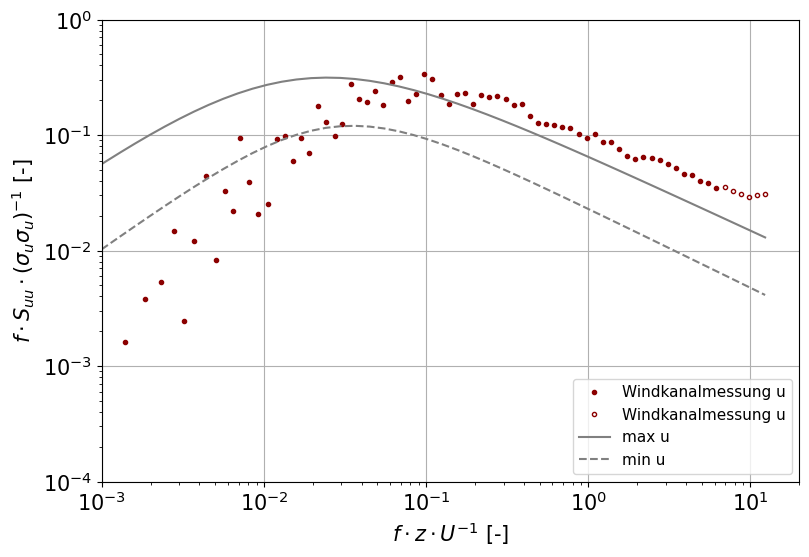

In [14]:
 ###Abb5.7: Plot Spectral density distribution

comps2Plot = ["u"] #["u","v","w"]
xLabel=r"$f\cdot z\cdot U^{-1}$ [-]" #r"$f\cdot z\cdot U^{-1}$ [-]"
yLabel=r"$f\cdot S_{uu}\cdot (\sigma_u\sigma_u)^{-1}$ [-]" #r"$f\cdot S_{ij}\cdot (\sigma_i\sigma_j)^{-1}$ [-]"
Labels=["Windkanalmessung u","Windkanalmessung u","max u","min u"]
showLegend=True
xAchse=(10**-3.,2.*10.**1.)
yAchse=(10**-4,10.**0.)
refRangeVis="maxMinLines" #"Interval" #"maxMinLines"

for name in namelist:
    #for file in files:
    if (mode == 1 or mode == 2 or mode== 5) and scatter:
        #edit 4/7/19: changed script to use dimensional wind values for calculating spectra to make sure that frequency is dimensionless
        spectra_data[name][file] = wt.calc_spectra(
                                            time_series_eq[name][file].u_eq.dropna()*time_series_eq[name][file].wtref,
                                            time_series_eq[name][file].v_eq.dropna()*time_series_eq[name][file].wtref,
                                            time_series_eq[name][file].t_eq[~np.isnan(time_series_eq[name][file].t_eq)],
                                            time_series_eq[name][file].z)
        # Plot spectra (in plots.bl.py)
        
        plt.figure(files.index(file)+400)
        wt.plots.plot_spectra(spectra_data[name][file][0],
                            spectra_data[name][file][1],
                            spectra_data[name][file][2],
                            spectra_data[name][file][4],
                            spectra_data[name][file][5],
                            wind_comps[name][file],
                            time_series[name][file].z,
                            ref_path=ref_path,
                            xLabel=xLabel,
                            yLabel=yLabel,
                            Labels=Labels,
                            showLegend=showLegend,
                            xAchse=xAchse,
                            yAchse=yAchse,
                            refRangeVis=refRangeVis,
                            comps2Plot=comps2Plot
                             )
        plt.savefig(plot_path + 'spectra_' + file[:-4] + '.' + file_type)
        plt.show()

In [ ]:
###3. Wavelet transformation
for name in namelist:
    for file in files:
        print('\n Start wavelet analysis for {}'.format(file))
        wavelet, scale = wt.calc_wavelet_transform(time_series[name][file].u_eq,
                                                time_series[name][file].t_eq,
                                                wavelet='morlet')
        # y_val = time_series[name][file].y-y_val_shift
        y_val = time_series[name][file].z            
        f_scale = y_val/(scale * np.mean(time_series[name][file].u_eq))

        # plot wavelet transform
        plt.figure(55)
        plt.style.use('classic')    
        wt.plots.plot_wavelet_transform(wavelet, 
                                scale, 
                                time_series[name][file].u_eq, 
                                time_series[name][file].t_eq,
                                y_val)

        plt.savefig(plot_path +  'wavelet_analysis_' + file +  '.' + file_type,
                    bbox_inches='tight', dpi=300)
        print(' Saved plot to:'+ plot_path + 'wavelet_analysis_' + file +  '.' + file_type)
        plt.show()
        #plt.close(55)
        print(' Finished wavelet analysis for {}'.format(file))

In [ ]:
## Abb5.4a: Plot turbulence intensity/I_u vertical profile (mode==1)

component2Plot="I_u" #'I_'+ts.wind_comp1
I_u_err= 0.01#I_u_err  #Error value to apply
shown_z_value=(0, 100) #(min, max) masking data higher or lower 

new_VDI_ref=True
VDI_values=[]

z_axis_lim = (0,100) #Vertical axsis to stil plot
Labels=["z0=5mm","z0=0.1m","z0=0.5m","z0=2m","Windkanalmessungen"]
xLabel= r"$I_{u} $ [-]"      #"Iu [-]" 
yLabel= r"$Z_{fs} [m] $ [-]" #"Z_fs[m]"
show_Legend=True

for name in namelist:
    if mode ==1:
    #for file in files:
        plt.style.use('default')
        # Turbulence intensity of the first component
        fig = plt.figure(2, dpi=dpi)
        wt.plots.plot_turb_int(I_u,heights,yerr=I_u_err,component='I_'+ts.wind_comp1,
                               ref_path=ref_path,new_ref=new_VDI_ref,
                               cut = shown_z_value,
                               Labels=Labels,xLabel=xLabel,yLabel=yLabel)
        if(z_axis_lim[0] != None) and (z_axis_lim[1] != None):
            plt.ylim(z_axis_lim)
        plt.tight_layout()
        plt.savefig(plot_path + 'I_'+ts.wind_comp1+'_' + name + '.' + file_type)
        plt.show()
       

In [ ]:
## Abb5.4a_2: Plot turbulence intensity/I_u vertical profile (mode==1)

component2Plot="I_u" #'I_'+ts.wind_comp1
I_u_err= 0.01#I_u_err  #Error value to apply
shown_z_value=(0, 100) #(min, max) masking data higher or lower 

z_axis_lim = (0,100) #Vertical axsis to stil plot
Labels=["z0=5mm","z0=0.1m","z0=0.5m","z0=2m","Windkanalmessungen"]
xLabel= r"$I_{u} $ [-]"      #"Iu [-]" 
yLabel= r"$Z_{fs} [m] $ [-]" #"Z_fs[m]"
show_Legend=True
LegendSize=0.001
figSize=(5,10)

new_VDI_ref=True
VDI_values=[]

#With other settings
#original_size  = fig.get_size_inches()
#original_width, original_height = original_size
#new_width = original_width/3


for name in namelist:
    if mode ==1:
        plt.style.use('default')
        fig = plt.figure(8, figsize = figSize, dpi=dpi)
        wt.plots.plot_turb_int(I_u,heights,
                               yerr=I_u_err,
                               component=component2Plot,
                               ref_path=ref_path,new_ref=new_VDI_ref,
                               cut = shown_z_value,
                               shown_Legend=show_Legend,xLabel=xLabel,yLabel=yLabel,Labels=Labels,LegendSize=LegendSize)
        """
        ax = plt.gca()
        ticks = np.linspace(0.05, 0.30, 5)
        ax.set_xticks(ticks)
        ax.set_xticklabels([f'{tick:.2f}' for tick in ticks])
        if (z_axis_lim[0] != None) and (z_axis_lim[1] != None):
            ax.set_ylim(z_axis_lim)
        #plt.xticks(rotation = 45)
        #plt.subplots_adjust(left=0.25, bottom = 0.12)
        plt.tight_layout()
        plt.savefig(plot_path + 'I_'+ts.wind_comp1+'_' + name + '_shrink' + '.' + file_type)
        plt.show()
        """
        if(z_axis_lim[0] != None) and (z_axis_lim[1] != None):
            plt.ylim(z_axis_lim)
        plt.tight_layout()
        plt.savefig(plot_path + 'I_'+ts.wind_comp1+'_' + name + '.' + file_type)
        plt.show()

In [ ]:
## Abb5.4b Plot turbulence intensity vertical profile for mode==1

component2Plot="I_w" #'I_'+ts.wind_comp1
y_err=0.005 #Error value to apply
shown_z_value=(0, 100) #(min, max) masking data higher or lower 

zref = 10
d0 = 0
Uref = 5
Kappa=0.4
new_VDI_ref=True
manuel_VDI=True #False
VDI_values = {    #{}
    "tm" : 3600,
    "Ave" : 0.18,
    "Av" : 1,
    "fu" :2.4,
    "fv" : 2,
    "fw" : 1.3
}

for key, value in VDI_values.items():
    globals()[key] = value

z_axis_lim = (0,100) #Vertical axsis to stil plot
Labels=["z0=5mm","z0=0.1m","z0=0.5m","z0=2m","Windkanalmessungen"]
xLabel= r"$I_{w} $ [-]"      #"Iu [-]" 
yLabel= r"$Z_{fs} [m] $ [-]" #"Z_fs[m]"

show_Legend=False
for name in namelist:
    if mode ==1:
    #for file in files:
        # Turbulence intensity of the second component
        plt.style.use('default')
        plt.figure(3, dpi=dpi)
        wt.plots.plot_turb_int(I_v,heights,yerr=y_err,
                               component='I_'+ts.wind_comp2,
                               ref_path=ref_path,
                               new_ref=new_VDI_ref,#manuel_VDI=manuel_VDI,values_VDI=VDI_values,
                               cut = shown_z_value,
                               Labels=Labels,xLabel=xLabel,yLabel=yLabel)
        if (z_axis_lim[0] != None) and (z_axis_lim[1] != None):
            print("Gets here")
            plt.ylim(z_axis_lim)
        plt.tight_layout()
        plt.savefig(plot_path + 'I_'+ts.wind_comp2+'_' + name + '.' + file_type)
        plt.show()

In [ ]:
#Abb5.5: Plot profile of vertical fluxes in surface layer
component='w'
flux_err=0.0001
invertxAchse=True
shown_z_value=(10, 60) #(min, max) masking data higher or lower 

xLabel=r' - u' + '\'' + component + '\' $\cdot U_{ref}^{-2}$ $[-]$'
yLabel=r' $Z_{fs}$ [m]' #" #'z full-scale (m)'
xAchse=(0.0,0.0070)
yAchse=(0,70)
showLegend=False

for name in namelist:
    #for file in files:
    if mode==1:

        if(invertxAchse==True):
            fluxes=fluxes * np.ones_like(fluxes)*(-1)
            
        plt.style.use('default')
        plt.figure(4, dpi=dpi) 
        wt.plots.plot_fluxes(fluxes,heights,
                             yerr=flux_err,component='w',cut=shown_z_value,
                             xLabel=xLabel,yLabel=yLabel,xAchse=xAchse,yAchse=yAchse,showLegend=showLegend)
        plt.tight_layout()
        plt.savefig(plot_path + 'fluxes_' + name + '.' + file_type)
        plt.show()

In [ ]:
#Abb 5.6: PLot lux / integrallength maß

component='w'
lux_err=10.0
Labels=["Windkanalmessungen","z0=10m (Theorie)","z0=1m (Theorie)","z0=0.1m (Theorie)","z0=0.01 (Theorie)",
        "Feldmessung (niedrige)","Feldmessung (hohe)"]
xLabel= r"$L_{ux} $ [m]"      #"Iu [-]" 
yLabel= r"$Z_{fs} $ [m]" #"Z_fs[m]"
xAchse= [10,1000]
yAchse= [0,300]  #min(heights)
showLegend=True
figSize=[13,9]

new_VDI_ref=True
manuel_VDI=True #False
VDI_values = {    #{}
    "Gamma" : 1/(1.55-0.01/z0+0.64/(z0**0.5)),
    "B"     : 3.12 + 19.92/(z0**0.5)-0.51/z0
}

for name in namelist:
    #for file in files:
    if mode==1:
        plt.style.use('default')
        plt.figure(6, dpi=dpi)
        #Double logarithmic profile of Lux data
        wt.plots.plot_lux(lux,heights,err=lux_err,component=component,
                          ref_path=ref_path,new_ref=new_VDI_ref,#manuel_VDI=manuel_VDI,values_VDI=VDI_values,
                         xLabel=xLabel,yLabel=yLabel,Labels=Labels,xAchse=xAchse,yAchse=yAchse,showLegend=showLegend,figSize=figSize)
        plt.tight_layout()
        plt.savefig(plot_path + 'Lux_' + name + '.' + file_type)
        plt.show()
        #plt.close('all')

In [ ]:
#Abb.5.3 Plot vertical wind profile with alpha (power law approach)
from windtunnel.flow import *
components=["u"] #["u","v","mag"]

err=0.04
Labels=["u"] #["u","v","magnitude"]
xLabel= r"$U/U_{ref} $ [-]"      #"Iu [-]" 
yLabel= r"$Z_{fs} $ [m]" #"Z_fs[m]"
xAchse= [0.0,1.0]
yAchse= [0,40]  #min(heights)
showLegend=False
figSize=[13,9]
fitAlpha=True
fitZ0=False

#Spontaneous zref and Uref for debugging
z_ref = 10 # np.arange(10, 80, 5)
height=10
u_ref = 5
sfc_layer=0


Kappa = 0.4
zref = 40
d0 = 0
Uref = 1.0
z = np.arange(10,305,5)
z0 = np.array([0.00001, 0.005, 0.1, 0.5, 2])


#u/uref = ((z-do)/(zref-d0))**alpha
for name in namelist: 
    if mode == 1 and plot:
        #Calculates the power law exponent alpha  by fitting of the vertical profiles of the mean wind u_mean
        if(fitAlpha==True):
            alpha, ref = calc_alpha(u_mean, heights)
            x = np.arange(0,len(u_mean),1)
            alpha=0.17
            profile2 = [Uref*((heights[i]- d0)/(z_ref - d0))**alpha for i in x] - np.ones_like(ref) * (0.26)
            print(profile2)
            #Estimate power law
            #profile3 = power_law(u_mean,height,Uref,zref,alpha)
            #print(profile3)

        if(fitZ0==True):
            #print(alpha)
            #Calculates the roughness length z0 and the power law exponent alpha by fitting of the vertical profiles of the mean wind u_mean.
            z0 = calc_z0(u_mean,heights,d0=0.,sfc_height=100.)
            z0= z0[0]
            #z0 = np.polyfit(u_mean[sfc_layer], np.log(heights[sfc_layer]-d0),deg=1)
            #u_mean_2 = np.exp(u_mean[sfc_layer]*z0) - heights[sfc_layer]+d0
                
            #Ustar = ((Uref * Kappa)/np.log((z-d0)/z0))
            #u_mean2 = np.abs(u_mean / np.ones_like(u_mean)*Uref - np.log((z-d0)/z0)/(np.log((zref-d0)/z0)))
            #U = (Ustar/Kappa)*np.log((z-d0)/z0)
            #print(Ustar)
            #print(u_mean2)
            
            #print(np.log(heights[sfc_layer]-d0))
            #profile3 = [((heights[i]- 0)/(z_ref - 0))**alpha for i in x] - np.ones_like(ref) * (0.26)
            #print(f"zo: {z0}")
            #print(len(z0))
        #Calculate profile exponent alpha and roughness length z_0, and save data to excel file.   
        #alpha = calc_alpha_profile(mean_mag, heights, wtref, z_ref, d_0=0, mode='all')
        #print(alpha)
        
        # Plot results of a vertical profile
        # Wind components
        plt.style.use('default')
        plt.figure(0, dpi=dpi)
        ret = wt.plots.plot_winddata(heights,u_mean=u_mean,mean_magnitude=mean_mag,components=components,yerr=err,
                                         xLabel=xLabel,yLabel=yLabel,Labels=Labels,xAchse=xAchse,yAchse=yAchse,showLegend=showLegend)
        
        #ret, lgd =U{ wt.plots.plot_winddata(mean_mag,u_mean,v_mean,heights,yerr=err,
        #                                 xLabel=xLabel,yLabel,Labels=Labels,xAchse=xAchse,yAchse=yAchse,showLegend=showLegend)
        #plt.savefig(plot_path + 'wind_data_' + name + '.' + file_type)#,
                    #bbox_extra_artists=(lgd,), bbox_inches='tight')
        plt.plot(profile2,heights,"k--",color="black")
        #plt.plot(profile3,heights,"k--",color="grey")
        plt.legend([f"alpha: {alpha}",Labels],loc="upper left")
        plt.show()
        print(len(u_mean))

In [ ]:
#Abb.5.3 Plot vertical wind profile with zo (logarithmic windprofile)
from windtunnel.flow import *


components=["u"] #["u","v","mag"]
err=0.01
fitAlpha=True
fitZ0=False

Labels=["Windkanalmessungen"] #["u","v","magnitude"]
xLabel= r"$U/U_{ref} $ [-]"      #"Iu [-]" 
yLabel= r"$Z_{fs} $ [m]" #"Z_fs[m]"
xAchse= [0.0,1.5]
yAchse= [0,100]  #min(heights)
showLegend=False
figSize=[13,9]

#Spontaneous zref and Uref for debugging
z_ref = 50 #10 # np.arange(10, 80, 5)

#Constants for profile calculation
Kappa = 0.4
d0 = 0
sfc_layer=0

x = np.arange(0,len(u_mean),1)
z = np.linspace(0,heights[-1],len(u_mean))
z_fit = np.linspace(10, 100, 100)
#z0 = np.array([0.00001, 0.005, 0.1, 0.5, 2])


for name in namelist: 
    if mode == 1 and plot:
        if(fitAlpha==True):
            #Calculates the power law exponent alpha  by fitting of the vertical profiles of the mean wind u_mea
            alpha, ref = calc_alpha(u_mean, heights)#heights)
            alpha=0.17
            fit_alpha = [((z_fit[i]- 0)/(z_ref - 0))**alpha for i in range(100)] #heights[i] - np.ones_like(ref) * (0.26)
            #fit_alpha = [((heights[i]- 0)/(z_ref - 0))**alpha for i in range(100)] 
            #Estimate power law
            #profile = power_law(u_mean,height,u_ref,z_ref,alpha)
            
            #Wind components
            plt.style.use('default')
            plt.figure(0, dpi=dpi)
            ret = wt.plots.plot_winddata(heights,u_mean=u_mean,mean_magnitude=mean_mag,components=components,yerr=err,
                                             xLabel=xLabel,yLabel=yLabel,Labels=Labels,xAchse=xAchse,yAchse=yAchse,showLegend=showLegend)
            #plt.plot(fit_alpha,heights,"k-",color="darkgrey",linewidth=0.5)
            plt.plot(fit_alpha,z_fit,"k-",color="darkgrey",linewidth=0.5)
            plt.legend([f"Profilexponent α = {alpha:.3f} ± {err}",Labels[0]],loc="upper left")
            plt.show()

        elif(fitZ0==True):
            #Calculates the roughness length z0 and the power law exponent alpha by fitting of the vertical profiles of the mean wind u_mean.
            z0 = calc_z0(u_mean,heights,d0=0.,sfc_height=100.)
            #z0= z0[0]
            print(z0)
            z0 = z0[0]
            
            u_star = (kappa ) / np.log((zref - d0) / z0)
            fit_z0 = (u_star / kappa) * np.log((z_fit - d0) / z0)
            #plt.style.use('default')
            plt.figure(0, dpi=dpi)
            ret = wt.plots.plot_winddata(heights,u_mean=u_mean,mean_magnitude=mean_mag,components=components,yerr=err,
                                             xLabel=xLabel,yLabel=yLabel,Labels=Labels,xAchse=xAchse,yAchse=yAchse,showLegend=showLegend)
            #plt.errorbar(u_mean, heights,xerr=0.1,fmt="o",c='darkred', label='Measurements', zorder=5,
            #ecolor="black",capsize=3.0)
            plt.plot(fit_z0,z_fit,"k-",color="darkgrey",linewidth=0.5)
            plt.legend([f"z0: {z0:.3f}",Labels[0]],loc="upper left")
            #plt.yscale('log')
            plt.show()
        else:
            #Just the vertical profile
            plt.style.use('default')
            plt.figure(0, dpi=dpi)
            ret = wt.plots.plot_winddata(heights,u_mean=u_mean,mean_magnitude=mean_mag,components=components,yerr=err,
                                             xLabel=xLabel,yLabel=yLabel,Labels=Labels,xAchse=xAchse,yAchse=yAchse,showLegend=showLegend)
            plt.legend([Labels],loc="upper left")
            plt.show()
            print(len(u_mean))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
# Parameters
alpha = 0.17      # Power law exponent
z0 = 0.1410726917895896 #0.0400 #0.014        # Roughness length [m]
zref = 50 #10         # Reference height [m]
#uref = 5          # Reference velocity [m/s]
d0 = 0            # Zero-plane displacement [m]
kappa = 0.4       # von Kármán constant

# Example data arrays (replace with your actual data)
#heights = np.array([10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70])  # [m]
#u_mean = np.array([3.2, 4.1, 4.7, 5.2, 5.6, 6.0, 6.3, 6.6, 6.8, 7.0, 7.2, 7.4, 7.5])  # [m/s]

# Generate fitted profiles
z_fit = np.linspace(10, 70, 100)

# Power law: u(z) = uref * (z/zref)^alpha
u_power = (z_fit / zref) ** alpha #- np.ones_like(z_fit)*0.32
#[((heights[i]- 0)/(z_ref - 0))**alpha for i in x] 

# Logarithmic law: u(z) = (u*/kappa) * ln((z-d0)/z0)
u_star = (kappa ) / np.log((zref - d0) / z0)
u_log = (u_star / kappa) * np.log((z_fit - d0) / z0)

# Create plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot 1: Linear scale
ax1.errorbar(u_mean, heights, xerr=0.04,c="darkred", fmt="o", label='Measurements', zorder=5,
              ecolor="black",capsize=3.0)
ax1.plot(u_power, z_fit, "k-", color="darkgrey",linewidth=0.5, label=f'Power Law (α={alpha:.3f})')
#ax1.plot(u_log, z_fit, "k--", color="grey",linewidth=2, label=f'Log Law (z₀={z0}m)')
ax1.set_xlabel('Velocity [-]')
ax1.set_ylabel('Height (m)')
ax1.set_title('Linear Scale')
ax1.grid(True)
ax1.legend()

# Plot 2: Logarithmic scale
ax2.errorbar(u_mean, heights,xerr=0.04,fmt="o",c='darkred', label='Measurements', zorder=5,
            ecolor="black",capsize=3.0)
#ax2.plot(u_power, z_fit, "k--", linewidth=2, label=f'Power Law (α={alpha})',color="black")
ax2.plot(u_log, z_fit, "k-", linewidth=0.5, label=f'Log Law (z₀={z0:.3f}m)',color="darkgrey")
ax2.set_xlabel('Velocity (m/s)')
ax2.set_ylabel('Height (m) - Log Scale')
ax2.set_yscale('log')
ax2.set_title('Logarithmic Scale')
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.suptitle('Wind Profile Analysis', y=1.02, fontsize=14)
plt.show()

# Print key parameters
print(f"Power Law: u = {uref}*(z/{zref})^{alpha}")
print(f"Log Law: u* = {u_star:.3f} m/s")
print(f"Log Law: u = ({u_star:.3f}/0.4)*ln((z-{d0})/{z0})")

In [ ]:
#Do Reynolds number independency test of mode==4
for name in namelist:
    if mode == 4:
        print("Reynolds independence test")
        # Perform and plot results of Reynolds Number Independence test, no
        # output saved as txt, as programme ends at "break"
        plt.style.use('default')
        plt.figure(0)
        wt.plots.plot_Re_independence(mean_mag, wtref, yerr=u_err,ymin=0,ymax=1)
        #wt.plots.plot_Re_independence(u_std, wtref, yerr=u_err,ymin=0,ymax=0.3)
        plt.tight_layout()
        plt.savefig(plot_path + 'Re_u' + name + '.' + file_type)
        plt.show()
        break

In [ ]:
# Plot results of a vertical profile
for name in namelist: 
    if mode == 1 and plot:
        # Plot results of a vertical profile
        # Wind components
        plt.style.use('default')
        plt.figure(0, dpi=dpi)
        ret, lgd = wt.plots.plot_winddata(mean_mag,u_mean,v_mean,heights,yerr=u_v_err)
        plt.savefig(plot_path + 'wind_data_' + name + '.' + file_type,
                    bbox_extra_artists=(lgd,), bbox_inches='tight')
        plt.show()
    
        # Wind components, logarithmic y-axis
        plt.style.use('default')
        plt.figure(1, dpi=dpi)
        ret, lgd = wt.plots.plot_winddata_log(mean_mag,u_mean,v_mean,heights,xerr=u_v_err)
        plt.tight_layout()
        plt.savefig(plot_path + 'wind_data_log_' + name + '.' + file_type,
                    bbox_extra_artists=(lgd,), bbox_inches='tight')
        plt.show()

        plt.style.use('default')
        # Turbulence intensity of the first component
        fig = plt.figure(2, dpi=dpi)
        wt.plots.plot_turb_int(I_u,heights,yerr=I_u_err,component='I_'+ts.wind_comp1,ref_path=ref_path,new_ref=new_VDI_ref,cut = shown_z_value)
        if (z_axis_lim[0] != None) and (z_axis_lim[1] != None):
            plt.ylim(z_axis_lim)
        plt.tight_layout()
        plt.savefig(plot_path + 'I_'+ts.wind_comp1+'_' + name + '.' + file_type)
        plt.show()
        
        original_size  = fig.get_size_inches()
        original_width, original_height = original_size
        new_width = original_width/3

        plt.style.use('default')
        fig = plt.figure(8, figsize = (new_width,original_height), dpi=dpi)
        wt.plots.plot_turb_int(I_u,heights,yerr=I_u_err,component='I_'+ts.wind_comp1,
                               ref_path=ref_path,new_ref=new_VDI_ref,cut = shown_z_value,
                               shown_Legend= False)
        if (z_axis_lim[0] != None) and (z_axis_lim[1] != None):
            plt.ylim(z_axis_lim)
        ax = plt.gca()
        ticks = np.linspace(0.05, 0.30, 5)
        ax.set_xticks(ticks)
        ax.set_xticklabels([f'{tick:.2f}' for tick in ticks])
        #plt.xticks(rotation = 45)
        plt.subplots_adjust(left=0.25, bottom = 0.12)
        plt.tight_layout()
        plt.savefig(plot_path + 'I_'+ts.wind_comp1+'_' + name + '_shrink' + '.' + file_type)
        plt.show()
        
        # Turbulence intensity of the second component
        plt.style.use('default')
        plt.figure(3, dpi=dpi)
        wt.plots.plot_turb_int(I_v,heights,yerr=I_v_err,component='I_'+ts.wind_comp2,ref_path=ref_path,new_ref=new_VDI_ref,cut = shown_z_value)
        if (z_axis_lim[0] != None) and (z_axis_lim[1] != None):
            plt.ylim(z_axis_lim)
        plt.tight_layout()
        plt.savefig(plot_path + 'I_'+ts.wind_comp2+'_' + name + '.' + file_type)
        plt.show()
        
        plt.style.use('default')
        plt.figure(7,figsize=(new_width,original_height), dpi=dpi)
        wt.plots.plot_turb_int(I_v,heights,yerr=I_v_err,component='I_'+ts.wind_comp2,
                               ref_path=ref_path,new_ref=new_VDI_ref,cut = shown_z_value,
                               shown_Legend = False)
        if (z_axis_lim[0] != None) and (z_axis_lim[1] != None):
            plt.ylim(z_axis_lim)
        ax = plt.gca()
        ticks = np.linspace(0.04, 0.22, 5)
        ax.set_xticks(ticks)
        ax.set_xticklabels([f'{tick:.2f}' for tick in ticks])
        #plt.xticks(rotation = 45)
        plt.subplots_adjust(left=0.25, bottom = 0.12)
        plt.tight_layout()
        plt.savefig(plot_path + 'I_'+ts.wind_comp2+'_' + name + '_shrink'+ '.' + file_type)
        plt.show()
    
        # Profile of the fluxes
        plt.style.use('default')
        plt.figure(4, dpi=dpi) 
        wt.plots.plot_fluxes(fluxes,heights,yerr=flux_err,component='w')
        plt.tight_layout()
        plt.savefig(plot_path + 'fluxes_' + name + '.' + file_type)
        plt.show()
    
        # Profiles of the fluxes, logarithmic y-axis
        plt.style.use('default')
        plt.figure(5, dpi=dpi)
        wt.plots.plot_fluxes_log(fluxes,heights,yerr=flux_err,component='w')
        plt.tight_layout()
        plt.savefig(plot_path + 'fluxes_log_' + name + '.' + file_type)
        plt.show()
    
        # Double logarithmic profile of Lux data
        plt.style.use('default')
        plt.figure(6, dpi=dpi)
        wt.plots.plot_lux(lux,heights,yerr=lux_err,component='w',ref_path=ref_path,new_ref=new_VDI_ref)
        plt.tight_layout()
        plt.savefig(plot_path + 'Lux_' + name + '.' + file_type)
        plt.show()
        #plt.close('all')
    
    if mode == 2:
        # Results of a lateral profile
        # Wind components
        plt.style.use('default')
        plt.figure(0, dpi=dpi)
        ret, lgd = wt.plots.plot_winddata(mean_mag,u_mean,v_mean,y,yerr=u_v_err,lat=True)
        plt.tight_layout()
        plt.savefig(plot_path + 'wind_data_' + name + '.' + file_type,
                    bbox_extra_artists=(lgd,), bbox_inches='tight')
        plt.show()
        
        # Turbulence intensity of the first component
        plt.style.use('default')
        plt.figure(1, dpi=dpi)
        if (z_axis_lim[0] != None) and (z_axis_lim[1] != None):
            plt.ylim(z_axis_lim)
        wt.plots.plot_turb_int(I_u,y,yerr=I_u_err,lat=True,new_ref=new_VDI_ref, cut = shown_z_value)
        plt.tight_layout()
        plt.savefig(plot_path + 'I_u_' + name + '.' + file_type)
        plt.show()
    
        # Turbulence intensity of the second component
        plt.style.use('default')
        plt.figure(2, dpi=dpi)
        if (z_axis_lim[0] != None) and (z_axis_lim[1] != None):
            plt.ylim(z_axis_lim)
        wt.plots.plot_turb_int(I_v,y,yerr=I_v_err,component='I_w',lat=True,new_ref=new_VDI_ref,cut = shown_z_value)
        plt.tight_layout()
        plt.savefig(plot_path + 'I_v_' + name + '.' + file_type)
        plt.show()
    
        # Profile of the fluxes
        plt.style.use('default')
        plt.figure(3, dpi=dpi) 
        wt.plots.plot_fluxes(fluxes,y,yerr=flux_err,component='v',lat=True)
        plt.tight_layout()
        plt.savefig(plot_path + 'fluxes_' + name + '.' + file_type)
        plt.show()
        
        # Profiles of the fluxes, logarithmic y-axis
        plt.style.use('default')
        plt.figure(5, dpi=dpi)
        wt.plots.plot_fluxes_log(fluxes,heights,yerr=flux_err,component='v')
        plt.tight_layout()
        plt.savefig(plot_path + 'fluxes_log_' + name + '.' + file_type)
        plt.show()
    
        # Lateral profile of Lux data
        plt.style.use('default')
        plt.figure(4, dpi=dpi)
        wt.plots.plot_lux(lux,y,yerr=lux_err,component='w',lat=True,new_ref=new_VDI_ref)
        plt.tight_layout()
        plt.savefig(plot_path + 'Lux_' + name + '.' + file_type)
        plt.show()
        
    if mode == 5:
        # Results of a lateral profile
        # Wind components
        plt.style.use('default')
        plt.figure(0, dpi=dpi)
        ret, lgd = wt.plots.plot_winddata(mean_mag,u_mean,v_mean,y,yerr=u_v_err,lat=True)
        plt.tight_layout()
        plt.savefig(plot_path + 'wind_data_' + name + '.' + file_type,
                    bbox_extra_artists=(lgd,), bbox_inches='tight')
        plt.show()
        
        # Turbulence intensity of the first component
        plt.style.use('default')
        plt.figure(1, dpi=dpi)
        if (z_axis_lim[0] != None) and (z_axis_lim[1] != None):
            plt.ylim(z_axis_lim)
        wt.plots.plot_turb_int(I_u,y,yerr=I_u_err,lat=True,new_ref=new_VDI_ref, cut = shown_z_value)
        plt.tight_layout()
        plt.savefig(plot_path + 'I_u_' + name + '.' + file_type)
        plt.show()
    
        # Turbulence intensity of the second component
        I_v_err=0.1
        plt.style.use('default')
        plt.figure(2, dpi=dpi)
        if (z_axis_lim[0] != None) and (z_axis_lim[1] != None):
            plt.ylim(z_axis_lim)
        wt.plots.plot_turb_int(I_v,y,yerr=I_v_err,component='I_w',lat=True,new_ref=new_VDI_ref,cut = shown_z_value)
        plt.tight_layout()
        plt.savefig(plot_path + 'I_v_' + name + '.' + file_type)
        plt.show()
    
        # Profile of the fluxes
        flux_err = 0.0005
        plt.style.use('default')
        plt.figure(3, dpi=dpi) 
        wt.plots.plot_fluxes(fluxes,y,yerr=flux_err,component='v',lat=True)
        plt.tight_layout()
        plt.savefig(plot_path + 'fluxes_' + name + '.' + file_type)
        plt.show()
        
        # Profiles of the fluxes, logarithmic y-axis
        flux_err = 0.001
        plt.style.use('default')
        plt.figure(5, dpi=dpi)
        wt.plots.plot_fluxes_log(fluxes,heights,yerr=flux_err,component='v')
        plt.tight_layout()
        plt.savefig(plot_path + 'fluxes_log_' + name + '.' + file_type)
        plt.show()
    
        # Lateral profile of Lux data
        lux_err=0.5
        plt.style.use('default')
        plt.figure(4,dpi=dpi)
        wt.plots.plot_lux(lux,y,err=lux_err,component='w',lat=True,new_ref=new_VDI_ref)
        plt.tight_layout()
        plt.savefig(plot_path + 'Lux_' + name + '.' + file_type)
        plt.show()